In [1]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image


In [2]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'

def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'


def generate_actual_predicted(Y_pred, X_test, Y_test):
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))

    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))

    return actual, predicted

In [ ]:
image_folder_path = '/content/drive/MyDrive/SpectogramInitial'

file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [ ]:
X_all = []
Y_all = []

file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2)
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))

In [ ]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = to_categorical(Y_all, num_classes=8)

(3018, 112, 170, 3)
(3018,)


In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/X_all.npy', X_all)
np.save('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/Y_all.npy', Y_all)

In [3]:
X_all = np.load('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/X_all.npy')
Y_all = np.load('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/Y_all.npy')
print(X_all.shape)
print(Y_all.shape)

(3018, 112, 170, 3)
(3018, 8)


In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)

In [5]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)

    lay = Flatten()(lay)

    lay = Dense(48)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [6]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 170, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 85, 56)        8288      
                                                                 
 batch_normalization (Batch  (None, 56, 85, 56)        224       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 56, 85, 56)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 43, 56)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 28, 43, 56)        0     

In [ ]:
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]


In [ ]:
history = model.fit(X_train, Y_train,
            batch_size=8,
            epochs=100,
            verbose=2,
            callbacks=my_callbacks)

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Bats_AUS/saved_model_19feb')


In [7]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Colab Notebooks/Bats_AUS/saved_model_19feb'
model = load_model(model_path)

19/19 [==============================] - 5s 228ms/step
Test loss: 0.07170522958040237 / Test accuracy: 0.9817880988121033
Confusion Matrix:
[[  5   0   0   0   0   0   0   0]
 [  0  24   0   0   1   0   0   0]
 [  0   0  22   0   0   0   0   0]
 [  0   0   0  59   1   0   0   0]
 [  0   0   0   0 331   0   1   1]
 [  0   0   0   0   0  53   1   0]
 [  0   0   1   1   1   0  21   0]
 [  0   0   1   0   1   0   1  78]]
Classification Report:
               precision    recall  f1-score   support

    A.tridens     1.0000    1.0000    1.0000         5
     E.bottae     1.0000    0.9600    0.9796        25
M.emarginatus     0.9167    1.0000    0.9565        22
      P.kuhli     0.9833    0.9833    0.9833        60
R.muscatellum     0.9881    0.9940    0.9910       333
    R.nasutus     1.0000    0.9815    0.9907        54
  R.aegyptius     0.8750    0.8750    0.8750        24
 T.perforatus     0.9873    0.9630    0.9750        81

     accuracy                         0.9818       604
    

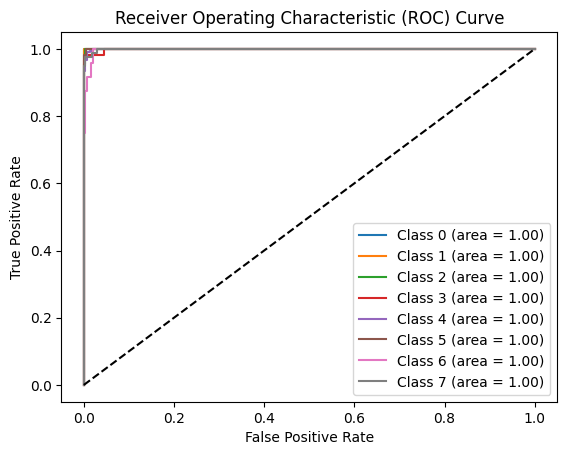

In [8]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming your model is saved as 'model.h5' and can be loaded as follows:
# model = load_model('model.h5')

# Class labels
labels = ['A.tridens', 'E.bottae', 'M.emarginatus', 'P.kuhli', 'R.muscatellum', 'R.nasutus', 'R.aegyptius', 'T.perforatus']


# Predict classes and probabilities for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

# For binary classification, adjust the shape of y_pred to match y_true
if y_pred.shape[1] == 1:
    y_pred = y_pred.ravel()

# Test scores
test_scores = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {test_scores[0]} / Test accuracy: {test_scores[1]}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Classification Report (Precision, Recall, F1-Score)
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=labels, digits=4))


# AUROC (Area Under the Receiver Operating Characteristic curve)
# Note: For multi-class, consider using a one-vs-rest approach
if len(Y_test[0]) == 2:  # Binary classification
    roc_auc = roc_auc_score(Y_test, y_pred)
    print(f'AUROC: {roc_auc}')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'AUROC (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:  # Multi-class classification
    # Compute ROC curve and ROC area for each class
    n_classes = Y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.96 0.   0.   0.04 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.98 0.02 0.   0.   0.  ]
 [0.   0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.98 0.02 0.  ]
 [0.   0.   0.04 0.04 0.04 0.   0.88 0.  ]
 [0.   0.   0.01 0.   0.01 0.   0.01 0.96]]


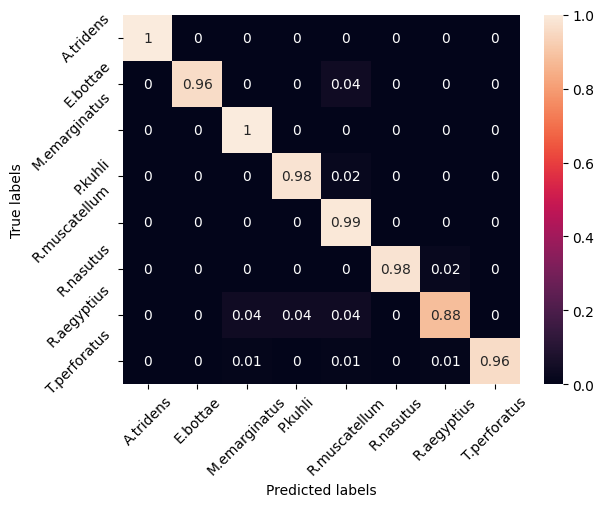

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= conf_matrix/ conf_matrix.sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
# ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);
plt.savefig('bat_confusion_mat.pdf', bbox_inches="tight")

In [ ]:
num_classes = 8
np.random.seed(0)  # For reproducible results

# Class labels
labels = ['A.tridens', 'E.bottae', 'M.emarginatus', 'P.kuhli', 'R.muscatellum', 'R.nasutus', 'R.aegyptius', 'T.perforatus']
colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))  # A unique color for each class

# # Function to plot ROC curve for each pair in a grid format
def plot_roc_curve_grid(y_true, y_pred, labels):
    num_classes = len(labels)
    fig, axes = plt.subplots(nrows=num_classes-1, ncols=num_classes-1, figsize=(20, 20))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(num_classes):
        for j in range(i+1, num_classes):
            ax = axes[j-1, i] if j < num_classes else axes[i, j-1]
            # Prepare binary class labels for the current pair
            # binary_y_true = np.where(y_true == i, 1, (np.where(y_true == j, 0, -1)))
            # binary_y_pred = y_pred[:, [i, j]].sum(axis=1)
            # binary_y_true = binary_y_true[binary_y_true != -1]
            # binary_y_pred = binary_y_pred[binary_y_true != -1]

            binary_y_test = y_true[:, [i, j]].sum(axis=1)
            binary_y_pred = y_pred[:, [i, j]].sum(axis=1)

            # Compute ROC curve and ROC area
            fpr, tpr, _ = roc_curve(binary_y_test, binary_y_pred, pos_label=1)
            roc_auc = auc(fpr, tpr)

            # Plot
            ax.plot(fpr, tpr, color=colors[i], label=f'ROC curve (area = {roc_auc:.2f})')
            ax.plot([0, 1], [0, 1], 'k--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_title(f'{labels[i]} vs {labels[j]}')
            ax.legend(loc="lower right",  fontsize=6)
            ax.set_title(f'{labels[i]} vs {labels[j]}', fontsize=10)
                    # Make plot border thinner
            for spine in ax.spines.values():
                spine.set_linewidth(0.5)  # Adjust linewidth here

    # Hide empty subplots
    for i in range(num_classes-1):
        for j in range(i+1, num_classes-1):
            axes[i, j].axis('off')

    fig.suptitle('Pairwise ROC Curves', fontsize=16)
    plt.savefig('pairwise_roc.pdf', format='pdf', bbox_inches='tight')




In [ ]:
y_pred.shape

In [ ]:
plot_roc_curve_grid(Y_test, y_pred, labels)

# tSNE

In [ ]:
model.layers[-5]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Convolution2D, BatchNormalization, Activation, MaxPooling2D, Dropout, AveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def build_feature_extractor():
    model = build_current_model()  # Your existing model building function
    # Create a new model that outputs the last hidden layer's output
    feature_extractor = Model(inputs=model.inputs, outputs=model.layers[-5].output)
    return feature_extractor

feature_extractor = build_feature_extractor()


In [ ]:
features = feature_extractor.predict(X_test)
# features = feature_extractor.predict(X_train)


19/19 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# It's often a good idea to apply some normalization or scaling before t-SNE
features_normalized = features - np.mean(features, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=90, n_iter=700)
tsne_results = tsne.fit_transform(features_normalized)


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 604 samples in 0.000s...
[t-SNE] Computed neighbors for 604 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 604 / 604
[t-SNE] Mean sigma: 0.008966
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.646400
[t-SNE] KL divergence after 700 iterations: 0.179702


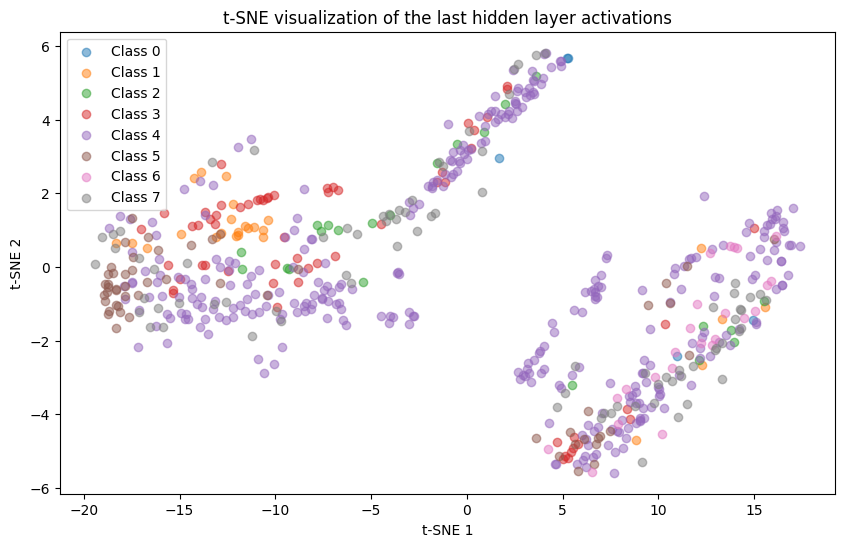

In [ ]:
import matplotlib.pyplot as plt

# If your labels are one-hot encoded, convert them to integers
y_test_integers = np.argmax(Y_test, axis=1)
# y_test_integers = np.argmax(Y_train, axis=1)

plt.figure(figsize=(10, 6))
for i in range(np.max(y_test_integers) + 1):
    indices = np.where(y_test_integers == i)
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {i}', alpha=0.5)
plt.legend()
plt.title('t-SNE visualization of the last hidden layer activations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Normalize features as a preprocessing step
features_normalized = features - np.mean(features, axis=0)

# Get unique classes
unique_classes = np.unique(y_test_integers)

# Apply t-SNE and plot for each class
for class_id in unique_classes:
    # Filter features for the current class
    class_features = features_normalized[y_test_integers == class_id]

    # Apply t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(class_features)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.title(f't-SNE for Class {class_id}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()


[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.385063
[t-SNE] KL divergence after 300 iterations: 0.109411


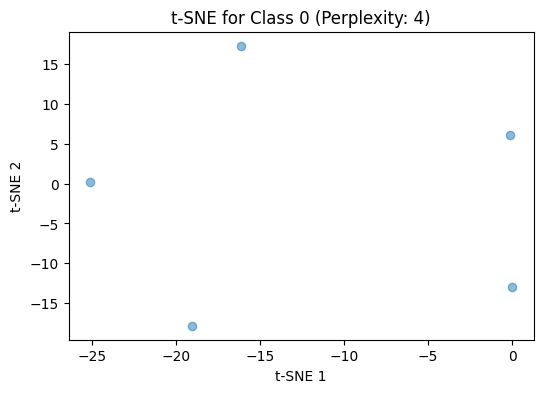

[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 1.490712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.404339
[t-SNE] KL divergence after 300 iterations: 0.440159


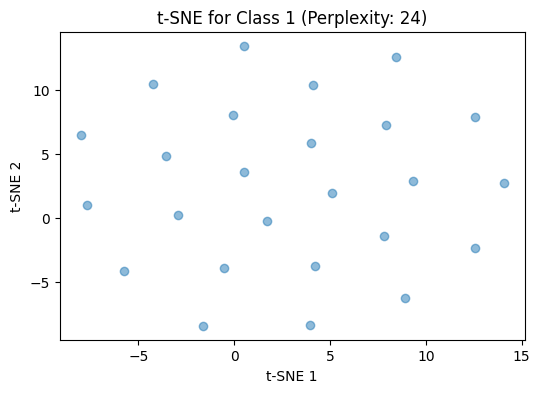

[t-SNE] Computing 21 nearest neighbors...
[t-SNE] Indexed 22 samples in 0.000s...
[t-SNE] Computed neighbors for 22 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 22 / 22
[t-SNE] Mean sigma: 1.313579
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.068596
[t-SNE] KL divergence after 300 iterations: 0.421155


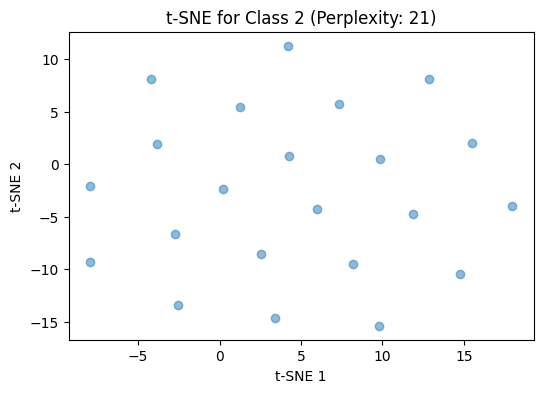

[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 0.025688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.646866
[t-SNE] KL divergence after 300 iterations: 0.019376


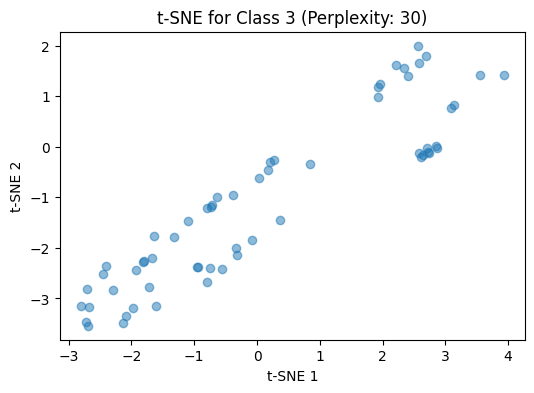

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 333 samples in 0.000s...
[t-SNE] Computed neighbors for 333 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 333 / 333
[t-SNE] Mean sigma: 0.011435
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.790504
[t-SNE] KL divergence after 300 iterations: 0.242666


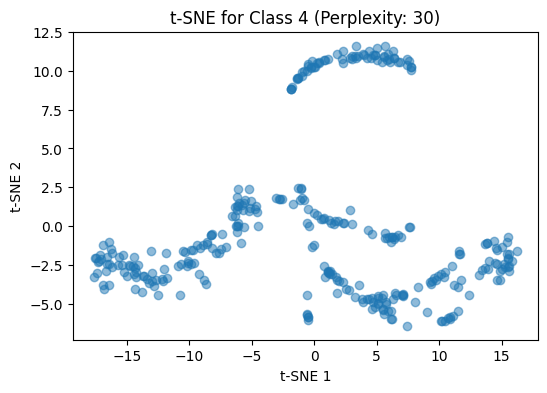

[t-SNE] Computing 53 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.023425
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.443230
[t-SNE] KL divergence after 300 iterations: 0.012564


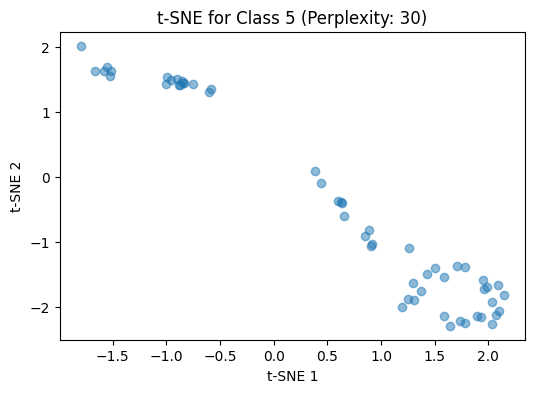

[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.000s...
[t-SNE] Computed neighbors for 24 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1.056541
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.972069
[t-SNE] KL divergence after 300 iterations: 0.439702


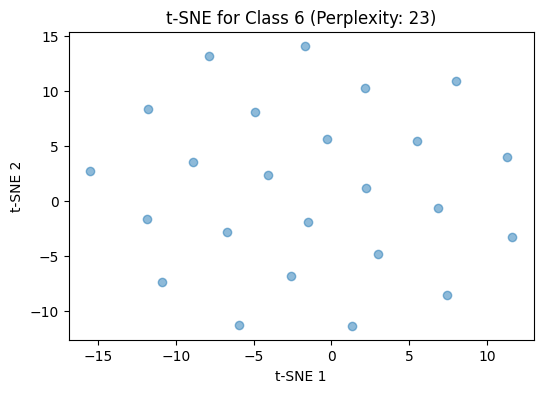

[t-SNE] Computing 80 nearest neighbors...
[t-SNE] Indexed 81 samples in 0.000s...
[t-SNE] Computed neighbors for 81 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 81 / 81
[t-SNE] Mean sigma: 0.039547
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.560246
[t-SNE] KL divergence after 300 iterations: 0.077325


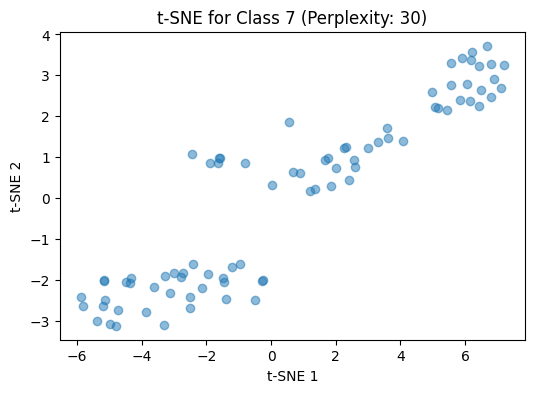

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Normalize features as a preprocessing step
features_normalized = features - np.mean(features, axis=0)

# Get unique classes
unique_classes = np.unique(y_test_integers)

# Apply t-SNE and plot for each class
for class_id in unique_classes:
    # Filter features for the current class
    class_features = features_normalized[y_test_integers == class_id]

    # Dynamically adjust perplexity based on the number of samples
    perplexity_value = min(30, len(class_features) - 1)  # Ensure perplexity is less than the number of samples

    # Apply t-SNE with adjusted perplexity
    if len(class_features) > 1:  # t-SNE requires at least 2 samples
        tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity_value, n_iter=300)
        tsne_results = tsne.fit_transform(class_features)

        # Plot
        plt.figure(figsize=(6, 4))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
        plt.title(f't-SNE for Class {class_id} (Perplexity: {perplexity_value})')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()
    else:
        print(f"Class {class_id} has less than 2 samples, skipping t-SNE visualization.")


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 604 samples in 0.001s...
[t-SNE] Computed neighbors for 604 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 604 / 604
[t-SNE] Mean sigma: 0.008450
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.917469
[t-SNE] KL divergence after 300 iterations: 0.451695


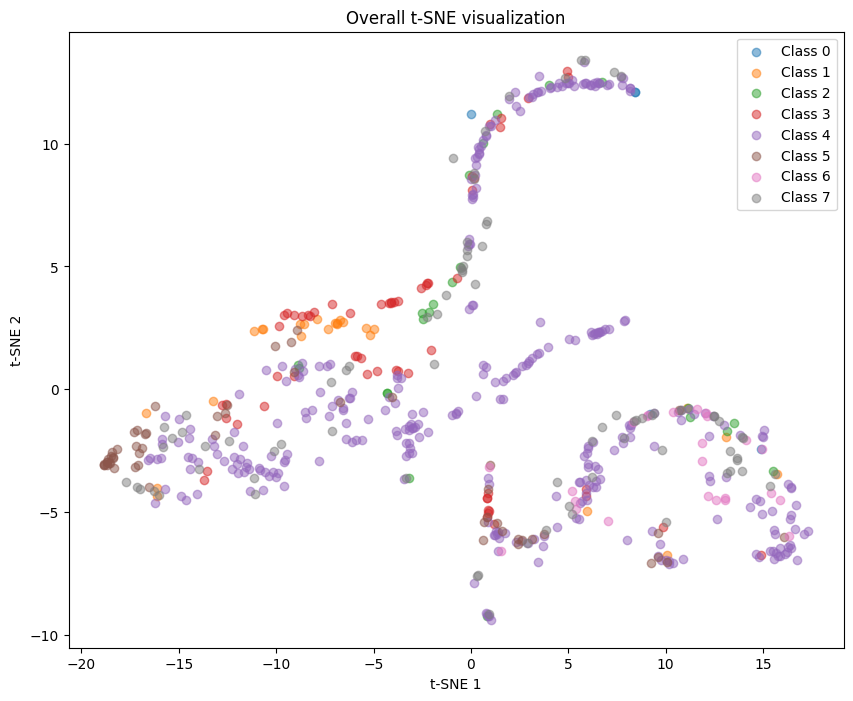

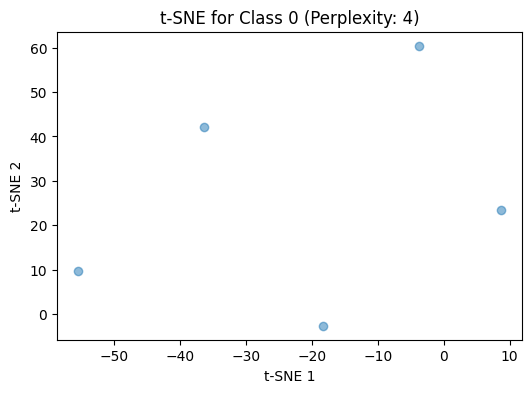

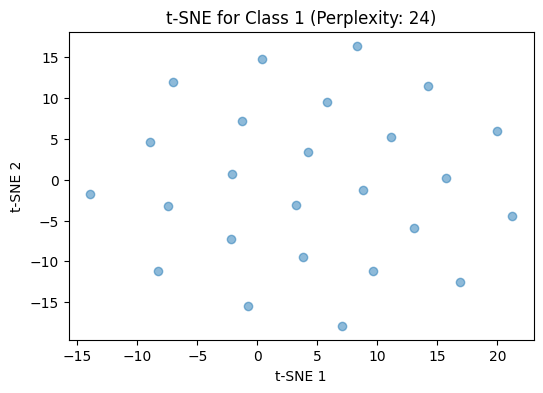

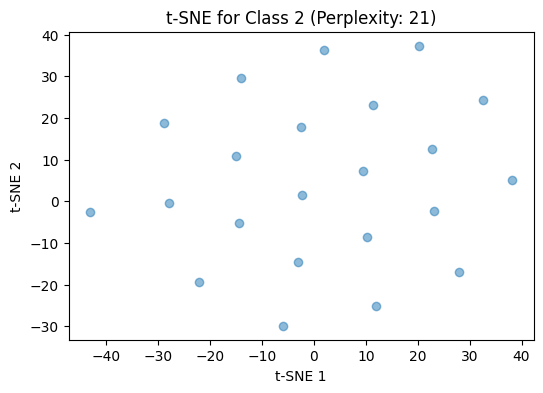

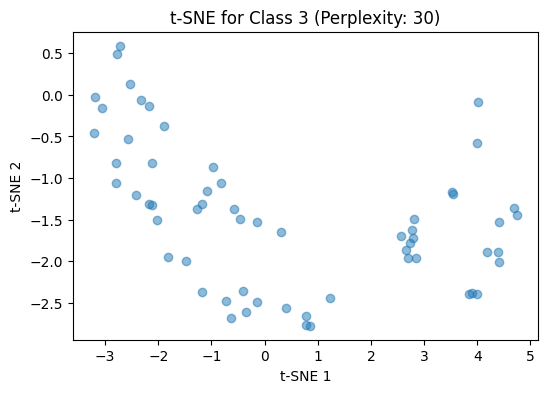

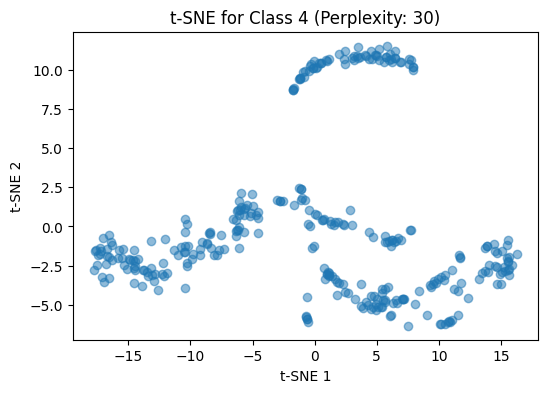

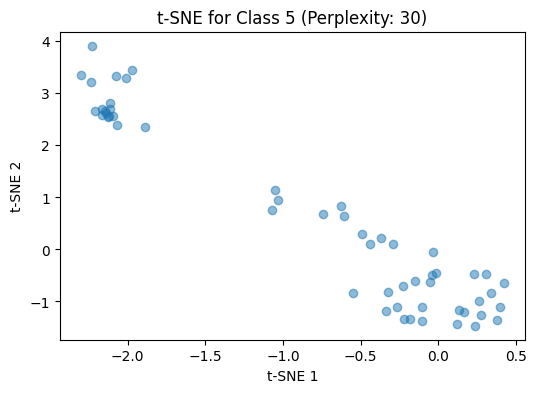

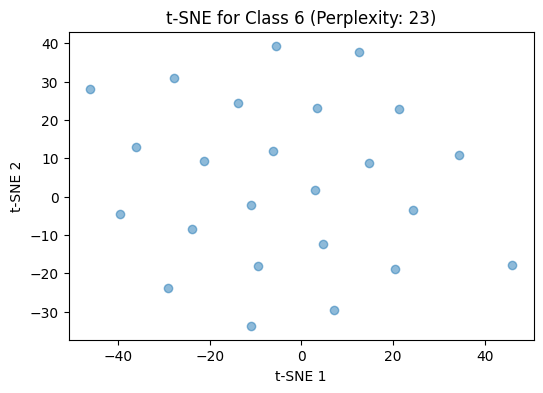

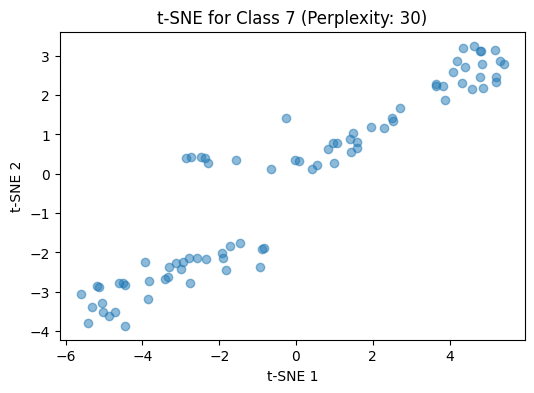

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'features_normalized' and 'y_test_integers' are defined as before

# Apply t-SNE to the entire normalized features
perplexity_value_overall = min(30, len(features_normalized) - 1)
tsne_overall = TSNE(n_components=2, verbose=1, perplexity=perplexity_value_overall, n_iter=300)
tsne_results_overall = tsne_overall.fit_transform(features_normalized)

# Plot overall t-SNE visualization with different colors for each class
plt.figure(figsize=(10, 8))
unique_classes = np.unique(y_test_integers)
for class_id in unique_classes:
    indices = np.where(y_test_integers == class_id)
    plt.scatter(tsne_results_overall[indices, 0], tsne_results_overall[indices, 1], label=f'Class {class_id}', alpha=0.5)

plt.legend()
plt.title('Overall t-SNE visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

# Now, proceed with class-specific t-SNE visualizations as before
for class_id in unique_classes:
    # Filter features for the current class
    class_features = features_normalized[y_test_integers == class_id]

    # Dynamically adjust perplexity based on the number of samples
    perplexity_value = min(30, len(class_features) - 1)

    # Apply t-SNE with adjusted perplexity
    if len(class_features) > 1:  # Ensure there are enough samples for t-SNE
        tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)
        tsne_results = tsne.fit_transform(class_features)

        # Plot class-specific visualization
        plt.figure(figsize=(6, 4))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
        plt.title(f't-SNE for Class {class_id} (Perplexity: {perplexity_value})')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()
    else:
        print(f"Class {class_id} has less than 2 samples, skipping t-SNE visualization.")


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2414 samples in 0.001s...
[t-SNE] Computed neighbors for 2414 samples in 0.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2414
[t-SNE] Computed conditional probabilities for sample 2000 / 2414
[t-SNE] Computed conditional probabilities for sample 2414 / 2414
[t-SNE] Mean sigma: 0.003791
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.374481
[t-SNE] KL divergence after 300 iterations: 1.208200


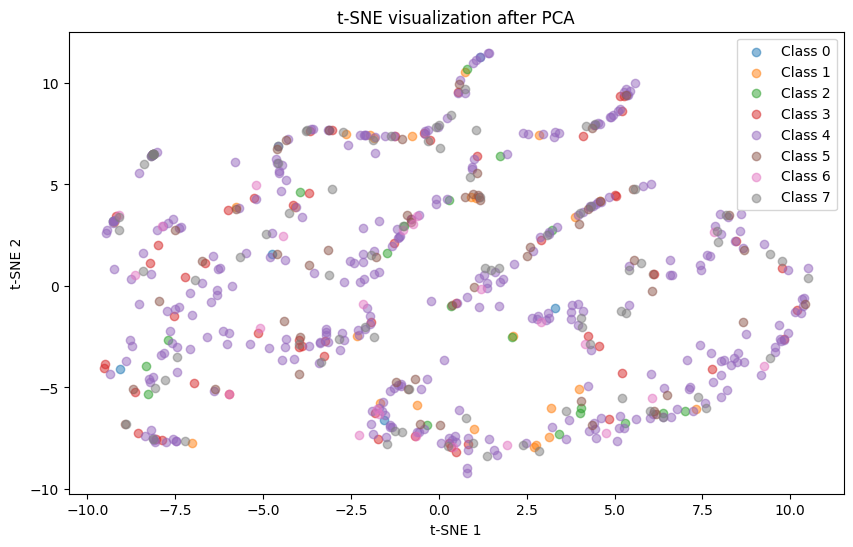

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# First, apply PCA to reduce dimensions to a manageable number
pca = PCA(n_components=40)
pca_result = pca.fit_transform(features_normalized)

# Then, apply t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)

# Visualization
plt.figure(figsize=(10, 6))
for i in range(np.max(y_test_integers) + 1):
    indices = np.where(y_test_integers == i)
    plt.scatter(tsne_pca_results[indices, 0], tsne_pca_results[indices, 1], label=f'Class {i}', alpha=0.5)
plt.legend()
plt.title('t-SNE visualization after PCA')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [ ]:
! pip install umap-learn


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


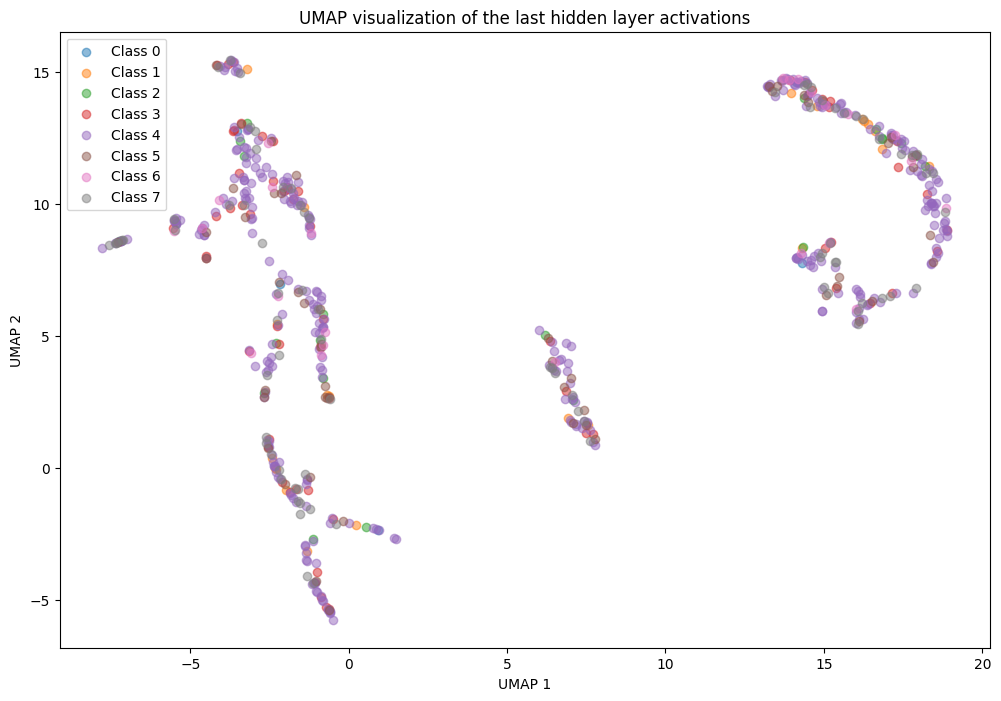

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'features' contains the activations from the last hidden layer
# and 'y_test_integers' contains the integer labels for your test dataset

# Normalize features as a preprocessing step
features_normalized = features - np.mean(features, axis=0)

# Initialize and fit UMAP
reducer = umap.UMAP(random_state=42)
umap_embeddings = reducer.fit_transform(features_normalized)

# Visualization
plt.figure(figsize=(12, 8))
for i in range(np.max(y_test_integers) + 1):
    indices = np.where(y_test_integers == i)
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=f'Class {i}', alpha=0.5)
plt.legend()
plt.title('UMAP visualization of the last hidden layer activations')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


# tSNE Test

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 604 samples in 0.013s...
[t-SNE] Computed neighbors for 604 samples in 2.087s...
[t-SNE] Computed conditional probabilities for sample 604 / 604
[t-SNE] Mean sigma: 8.803473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.510342
[t-SNE] KL divergence after 300 iterations: 0.384307


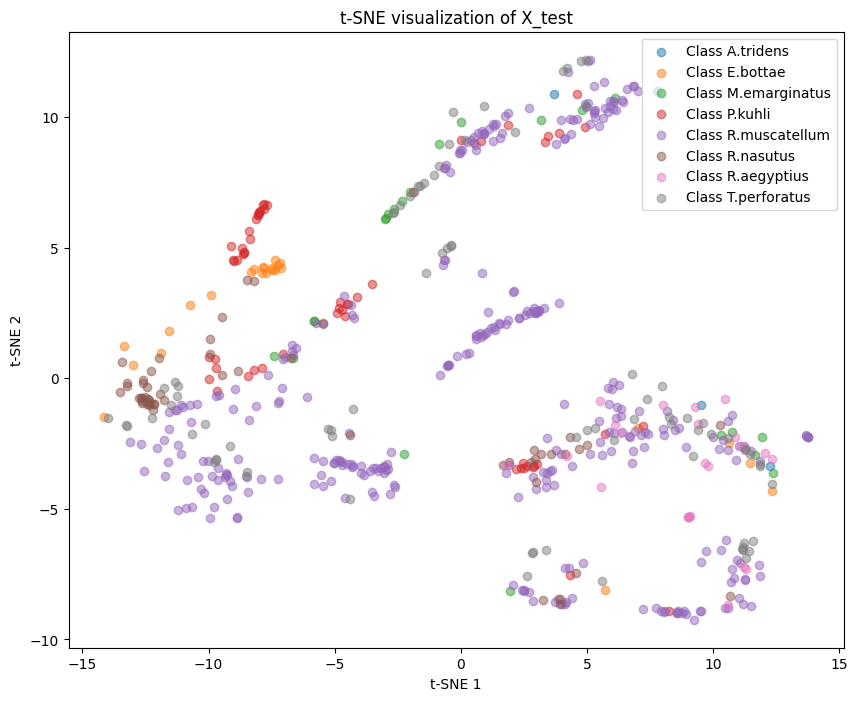

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test is your test features and Y_test are the corresponding labels
# Flatten X_test if it's multidimensional (e.g., images)
if len(X_test.shape) > 2:
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
else:
    X_test_flattened = X_test

# Apply t-SNE transformation
# Note: Adjust perplexity and n_iter for your specific dataset
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_test_flattened)

# Assuming Y_test contains integer labels for classification
# If Y_test is one-hot encoded, convert it to integer labels
if Y_test.ndim > 1:
    y_test_integers = np.argmax(Y_test, axis=1)
else:
    y_test_integers = Y_test

# Visualization
plt.figure(figsize=(10, 8))
unique_classes = np.unique(y_test_integers)
for i in unique_classes:
    indices = np.where(y_test_integers == i)
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {labels[i]}', alpha=0.5)

plt.legend()
plt.title('t-SNE visualization of X_test')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 604 samples in 0.020s...
[t-SNE] Computed neighbors for 604 samples in 3.876s...
[t-SNE] Computed conditional probabilities for sample 604 / 604
[t-SNE] Mean sigma: 13.786694
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.643696
[t-SNE] KL divergence after 700 iterations: 0.163678


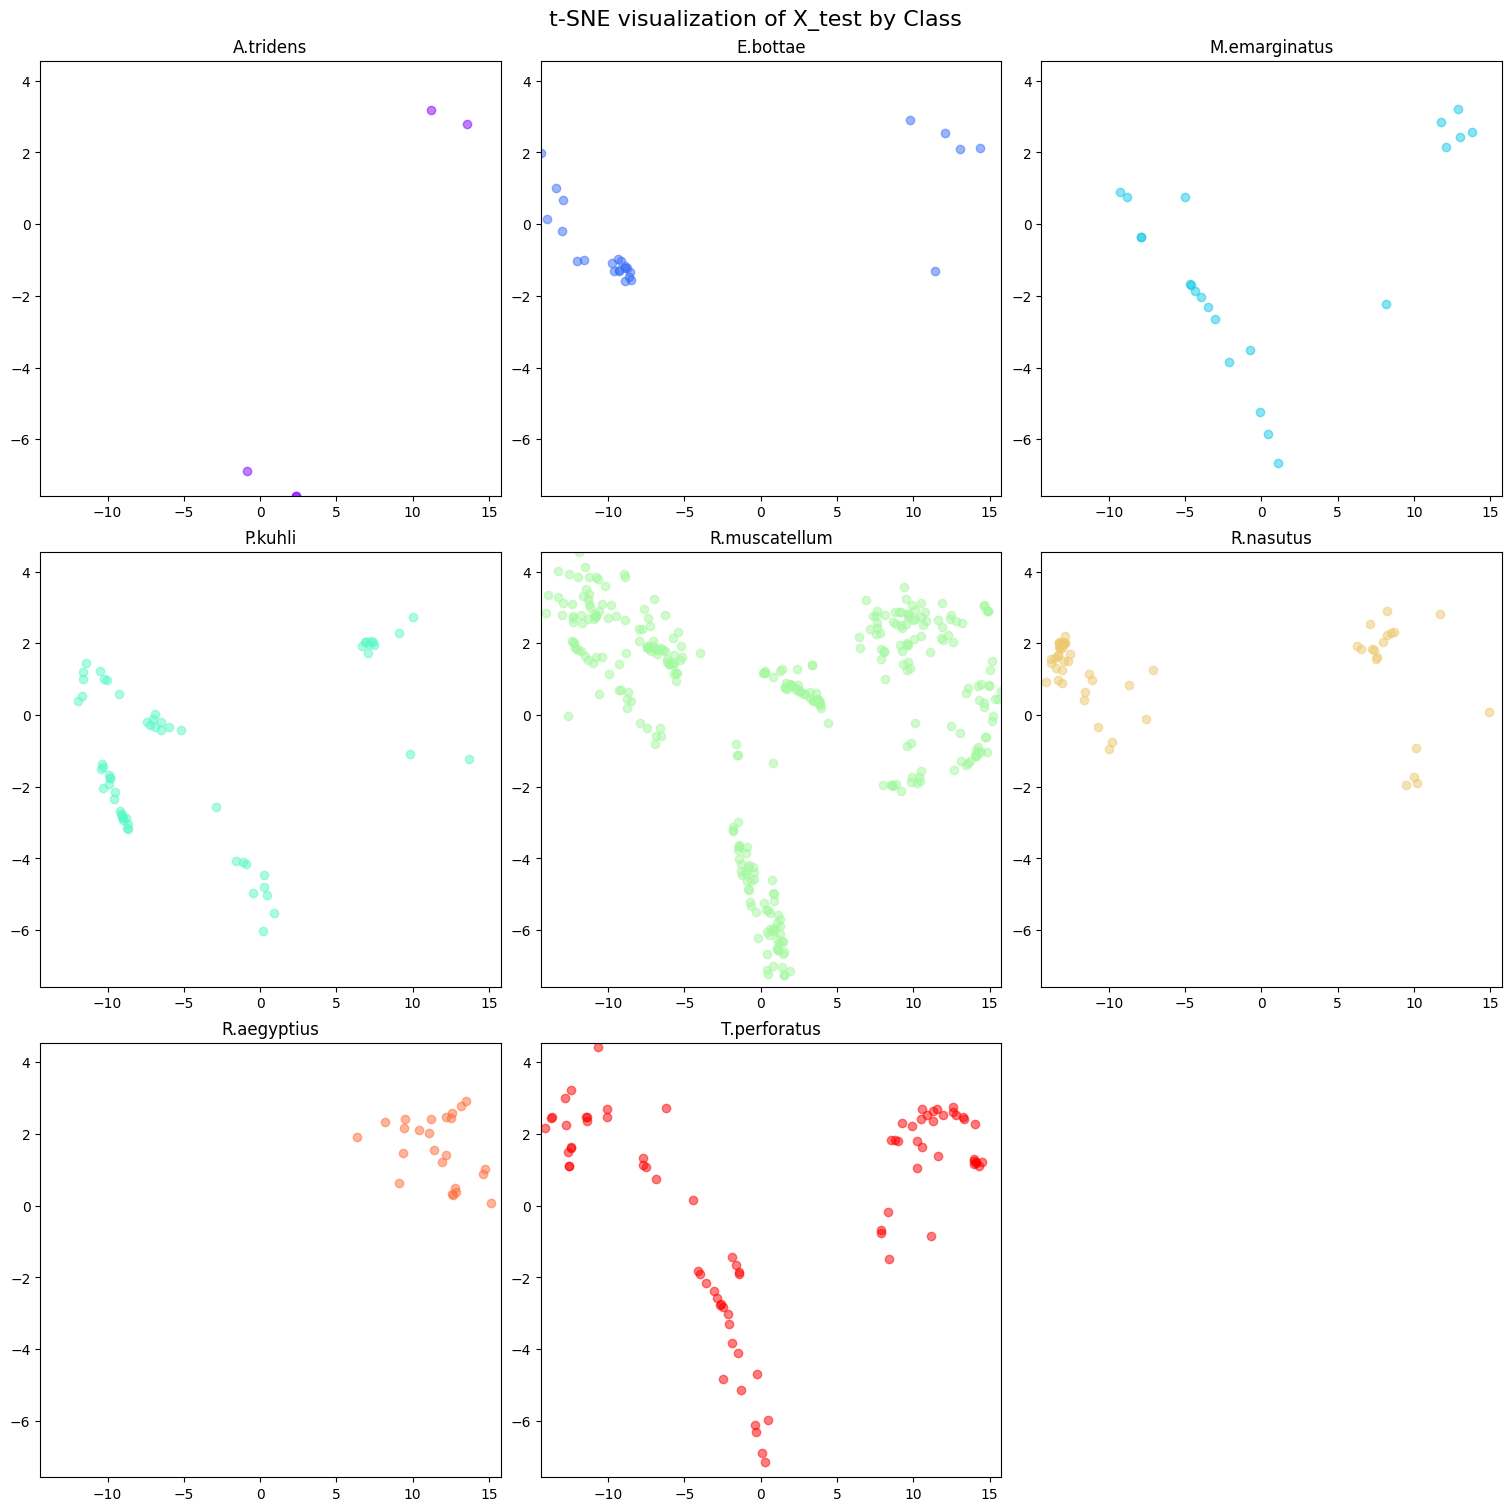

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test is your test features and Y_test are the corresponding labels
# Flatten X_test if it's multidimensional (e.g., images)
if len(X_test.shape) > 2:
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
else:
    X_test_flattened = X_test

# Apply t-SNE transformation
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=700)
tsne_results = tsne.fit_transform(X_test_flattened)

# Assuming Y_test contains integer labels for classification
if Y_test.ndim > 1:
    y_test_integers = np.argmax(Y_test, axis=1)
else:
    y_test_integers = Y_test

# Labels array
labels = ['A.tridens', 'E.bottae', 'M.emarginatus', 'P.kuhli', 'R.muscatellum', 'R.nasutus', 'R.aegyptius', 'T.perforatus']

# Visualization
unique_classes = np.unique(y_test_integers)
n_classes = len(unique_classes)

# Colors for each subplot
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

# Determine the number of rows/columns for the subplot grid
n_rows = int(np.ceil(np.sqrt(n_classes)))
n_cols = int(np.ceil(n_classes / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5), constrained_layout=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Find global axis limits
x_min, x_max = tsne_results[:, 0].min(), tsne_results[:, 0].max()
y_min, y_max = tsne_results[:, 1].min(), tsne_results[:, 1].max()

for i, ax in enumerate(axes):
    if i < n_classes:
        class_id = unique_classes[i]
        indices = np.where(y_test_integers == class_id)
        ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], alpha=0.5)
        ax.set_title(f'{labels[class_id]}')
        # Set the same axis limits for all subplots
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    else:
        ax.axis('off')  # Hide unused subplots

plt.suptitle('t-SNE visualization of X_test by Class', fontsize=16)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_test is your test features and Y_test are the corresponding labels
# Flatten X_test if it's multidimensional (e.g., images)
if len(X_test.shape) > 2:
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
else:
    X_test_flattened = X_test

# Apply t-SNE transformation
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_test_flattened)

# Assuming Y_test contains integer labels for classification
if Y_test.ndim > 1:
    y_test_integers = np.argmax(Y_test, axis=1)
else:
    y_test_integers = Y_test

# Labels array
labels = ['A.tridens', 'E.bottae', 'M.emarginatus', 'P.kuhli', 'R.muscatellum', 'R.nasutus', 'R.aegyptius', 'T.perforatus']

# Visualization
unique_classes = np.unique(y_test_integers)
n_classes = len(unique_classes)

# Colors for each subplot
colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

# Find global axis limits
x_min, x_max = tsne_results[:, 0].min(), tsne_results[:, 0].max()
y_min, y_max = tsne_results[:, 1].min(), tsne_results[:, 1].max()

for i in range(n_classes):
    class_id = unique_classes[i]
    indices = np.where(y_test_integers == class_id)

    plt.figure(figsize=(6, 5))
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[i], alpha=0.5)
    plt.title(f'{labels[class_id]}')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')

    # Save the figure using the label for the file name
    # Replace spaces with underscores and make lowercase for the file name
    file_name = labels[class_id].replace(' ', '_').lower() + '.png'
    plt.savefig(file_name, format='png', dpi=300)
    plt.close()  # Close the plot to avoid displaying it inline if running in a notebook


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 604 samples in 0.067s...
[t-SNE] Computed neighbors for 604 samples in 3.429s...
[t-SNE] Computed conditional probabilities for sample 604 / 604
[t-SNE] Mean sigma: 8.803473
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.511887
[t-SNE] KL divergence after 300 iterations: 0.384451
